## Sparse flight data

A key question for the generation of sparse state networks is _how_ sparse. If we lump all state nodes with each physical node, we lose all higher-order information and may underfit. On the other hand, keeping all second-order state nodes may overfit.

In this tutorial we will generate second-order state networks from path data and from there generate multiple sparse networks with different number of (lumped) state nodes and evaluate the result with Infomap

### Generate training and validation sets
To get a bigger network, we can merge the flight path data from the four quarters (`"data/air2015_{q}_paths.net" for q in [1,2,3,4]`). But to evaluate the goodness of fit, we can split each path randomly in either a _training_ or a _validation_ set and write a path data file for each of the data set.

In [1]:
from random import random

def generateData(inputFilenames):
    """Merge path data from inputFilenames and write to two path data files
    for training and validation. Each path in the input data is selected by
    random to be written to either the training or validation data file"""
    data = { 'training': [], 'validation': [] }
    # Read path data
    for filename in inputFilenames:
        print("Parsing paths from '{}'...".format(filename))
        with open(filename, mode='r') as infile:
            isPath = False
            for row in infile:
                if not isPath and row[:6] == "*paths":
                    isPath = True
                    continue
                if not isPath:
                    continue
                if random() < 0.5:
                    data['validation'].append(row)
                else:
                    data['training'].append(row)
    # Write path data
    for name, paths in data.items():
        outFilename = "output/paths_{}.net".format(name)
        print("-> Writing {} paths to {}...".format(len(paths), outFilename))
        with open(outFilename, mode='w') as outfile:
            outfile.write("*paths\n")
            for p in paths:
                outfile.write(p)

inputFilenames = ["data/air2015_{}_paths.net".format(quarter) for quarter in [1,2,3,4]]
generateData(inputFilenames)

Parsing paths from 'data/air2015_1_paths.net'...
Parsing paths from 'data/air2015_2_paths.net'...
Parsing paths from 'data/air2015_3_paths.net'...
Parsing paths from 'data/air2015_4_paths.net'...
-> Writing 33697 paths to output/paths_training.net...
-> Writing 33328 paths to output/paths_validation.net...


#### Generate state networks from paths

In [2]:
import infomap
def generateStateNetworkFromPaths(inputFilename, outputFilename, markovOrder):
    network = infomap.Network("--directed --path-markov-order {}".format(markovOrder))
    print("Reading {}...".format(inputFilename))
    network.readInputData(inputFilename)
    print("Writing {}...".format(outputFilename))
    network.writeStateNetwork(outputFilename)

generateStateNetworkFromPaths("output/paths_training.net", "output/states_training_order_2.net", 2)
generateStateNetworkFromPaths("output/paths_validation.net", "output/states_validation_order_2.net", 2)

Reading output/paths_training.net...
Writing output/states_training_order_2.net...
Reading output/paths_validation.net...
Writing output/states_validation_order_2.net...


### Generate _sparse_ state networks

Here we will generate multiple lumped state networks with different amount of state nodes. A simple way is to parameterise this with a cluster rate $r$ going from 0.1 to 1, where `n_clusters = max(1, int(r * numStateNodes)`. For convenience, you can just send in the argument `clusterRate` to `clusterStateNodes` to achieve this, instead of the cluster function in the previous tutorial.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from state_lumping_network import StateNetwork

sparseNet = StateNetwork()
sparseNet.readFromFile("output/states_training_order_2.net")

h0 = sparseNet.calcEntropyRate()
print("\nOriginal average entropy rate:", h0)
print("Original number of state nodes:", sparseNet.numStateNodes())

clusterRates = np.linspace(0.1, 1, 10)
numStates = []
entropyRate = []

for i, clusterRate in enumerate(clusterRates):
    sparseNet.clusterStateNodes(clusterRate=clusterRate)
    s = sparseNet.numLumpedStateNodes()
    h = sparseNet.calcLumpedEntropyRate()
    sparseNet.writeLumpedStateNetwork("output/states_training_lumped_{}.net".format(i))
    numStates.append(s)
    entropyRate.append(h)

Read state network from file 'output/states_training_order_2.net'...
 -> StateNetwork (351 physical nodes, 5191 state nodes and 20201 links)

Original average entropy rate: 3.887406843454422
Original number of state nodes: 5191
Cluster state nodes...
Generate lumped state network from clustering...
 -> 784 state nodes and 8210 links in lumped network.
Writing lumped state network to file 'output/states_training_lumped_0.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 1063 state nodes and 10730 links in lumped network.
Writing lumped state network to file 'output/states_training_lumped_1.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 1358 state nodes and 12412 links in lumped network.
Writing lumped state network to file 'output/states_training_lumped_2.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 1669 state nodes and 14026 links in lumped network.
Writing lumped state network

#### How much information do we lose as we reduce the number of state nodes?

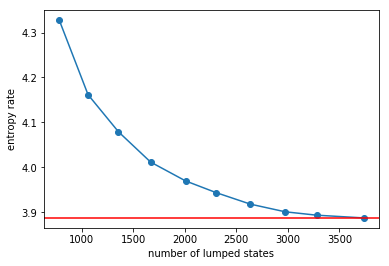

In [4]:
plt.plot(numStates, entropyRate, marker='o')
plt.xlabel("number of lumped states")
plt.ylabel("entropy rate")
plt.axhline(y=h0, color='r', linestyle='-')
# plt.axvline(x=sparseNet.numStateNodes(), color='r')
plt.show()

Note that the original number of state nodes can be much larger than the maximum in the lumped state networks due to dangling nodes which are lumped implicitly.

### Validate with Infomap
The goal here is to calculate the codelength for the validation network, given the different partitions found on the lumped training networks.

In [6]:
trainingCodelengths = []
validationCodelengths = []

def calcCodelength(inputFilename, cluInputFile, flags="--directed --two-level"):
    im = infomap.Infomap("{} --no-infomap --input {} --cluster-data {}".format(flags, inputFilename, cluInputFile))
    im.run()
    return im.codelength()

def partition(inputFilename, cluOutputFile=None, flags="--directed --two-level"):
    im = infomap.Infomap(flags)
    im.network().readInputData(inputFilename)
    im.run()
    if cluOutputFile:
        # Use second argument True to write the state-level clustering
        im.writeClu(cluOutputFile, True) # Second parameter shows States
    return im.codelength()


for i, clusterRate in enumerate(clusterRates):
    trainingCodelength = partition("output/states_training_lumped_{}.net".format(i),
             "output/states_training_lumped_{}.clu".format(i))
    validationCodelength = calcCodelength("output/states_validation_order_2.net",
             "output/states_training_lumped_{}.clu".format(i))
    trainingCodelengths.append(trainingCodelength)
    validationCodelengths.append(validationCodelength)
    print("{}: training codelength: {}, validation codelength: {}".format(i, trainingCodelength, validationCodelength))
    



0: training codelength: 7.550674714449653, validation codelength: 11.838026721702226
1: training codelength: 7.778881740421356, validation codelength: 12.140050672133592
2: training codelength: 7.728541914735246, validation codelength: 12.193429334875812
3: training codelength: 7.6219669913265164, validation codelength: 12.176362192962259
4: training codelength: 7.514583549836058, validation codelength: 12.201124314709695
5: training codelength: 7.463096062807431, validation codelength: 12.205834652198668
6: training codelength: 7.418770366761213, validation codelength: 12.25203275108717
7: training codelength: 7.372582922969545, validation codelength: 12.168403060171698
8: training codelength: 7.369295468647736, validation codelength: 12.175225522579652
9: training codelength: 7.352775997447965, validation codelength: 12.182925943136285


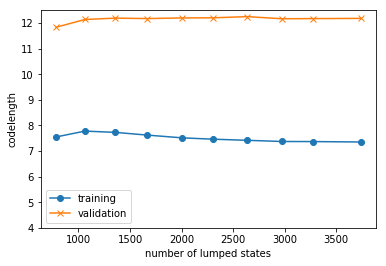

In [7]:
plt.plot(numStates, trainingCodelengths, marker='o')
plt.plot(numStates, validationCodelengths, marker='x')
plt.legend(["training", "validation"])
plt.xlabel("number of lumped states")
plt.ylabel("codelength")
plt.ylim(ymin=4)
plt.show()